In [83]:
import json
import os

import chromadb
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn.functional as F
from chromadb.utils import embedding_functions
from tqdm.notebook import tqdm
from transformers import AutoModel, AutoTokenizer

In [84]:
# https://docs.trychroma.com/guides
CHROMA_DATA_PATH = "chroma_data"
# CHROMA_DATA_PATH = r"C:\Users\ihett\OneDrive\Gabrilyi\arxiv_project\chroma_data"

# Sentence Transformers models
# EMBED_MODEL = "all-MiniLM-L6-v2"
# EMBED_MODEL = "all-mpnet-base-v2"

# LMStudio (ChristianAzinn/gte-small-gguf/gte-small.Q4_0.gguf)
# EMBED_MODEL = "gte-small-gguf"


# https://huggingface.co/sentence-transformers/allenai-specter
# EMBED_MODEL = "allenai-specter"

# https://huggingface.co/avsolatorio/GIST-small-Embedding-v0
EMBED_MODEL = "GIST-small-Embedding-v0"


COLLECTION_NAME = "arxiv_papers"
BATCH_SIZE = 5000

CHROMA_DATA_PATH = os.path.join(CHROMA_DATA_PATH, EMBED_MODEL)

In [85]:
cache_dir = 'cache'
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)

parquet_path = '../data/arxiv_metadata_sample.parquet.gzip'
# parquet_path = r"C:\Users\ihett\OneDrive\Gabrilyi\arxiv_project\arxiv_metadata_sample.parquet.gzip"
arxiv_df = pd.read_parquet(parquet_path)
# arxiv_df = arxiv_df.sample(20000)

print(arxiv_df.shape)

(119503, 14)


In [86]:
def text_processing(sample):
    title = sample['title']
    abstract = sample['abstract']

    # remove special characters
    title = title.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    abstract = abstract.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')

    # remove multiple spaces
    title = ' '.join(title.split())
    abstract = ' '.join(abstract.split())

    return f"Title: {title} - Abstract: {abstract}"

In [87]:
arxiv_df['text'] = arxiv_df.apply(text_processing, axis=1)
arxiv_df.head(3)

,id,title,abstract,categories,update_date,title_words,abstract_words,mapped_categories,amount_categories,update_year,super_categories,amount_super_categories,super_categories_str,super_category,text
0,2306.01499,Can LLMs like GPT-4 outperform traditional AI ...,Recent investigations show that large langua...,"[cs.CL, cs.LG]",2023-06-05,15,163,"[Computation and Language, Machine Learning]",2,2023,"[Artificial Intelligence, Artificial Intellige...",2,Computer Science and Artificial Intelligence,Artificial Intelligence,Title: Can LLMs like GPT-4 outperform traditio...
1,2312.05019,Vision-based Learning for Drones: A Survey,Drones as advanced cyber-physical systems ar...,"[cs.RO, cs.AI]",2024-01-03,6,181,"[Robotics, Artificial Intelligence]",2,2024,"[Artificial Intelligence, Artificial Intellige...",2,Computer Science and Artificial Intelligence,Artificial Intelligence,Title: Vision-based Learning for Drones: A Sur...
2,2307.14359,A new derivative-free optimization method: Gau...,Optimization methods are essential in solvin...,"[math.OC, cs.LG]",2023-07-28,8,114,"[Optimization and Control, Machine Learning]",2,2023,"[Engineering and Technology, Artificial Intell...",2,Computer Science and Artificial Intelligence E...,Artificial Intelligence,Title: A new derivative-free optimization meth...


In [88]:
def create_metadatas(arxiv_df):
    metadatas = []
    for _, row in arxiv_df.iterrows():
        metadatas.append({
            "update_date": row['update_date'],
            "title_words": row['title_words'],
            "abstract_words": row['abstract_words'],
            "super_category": row['super_category'],
            "mapped_categories": ";".join(row['mapped_categories']),
        })

    return metadatas

In [89]:
def create_collection(client, collection_name, embedding_function):
    collection = client.create_collection(
        name=collection_name,
        embedding_function=embedding_function,
        metadata={"hnsw:space": "cosine"},
        get_or_create=True,
    )

    return collection

def delete_collection_data(client, collection, collection_name):
    print(f"Deleting data from collection {collection_name} with {collection.count()} documents")
    client.delete_collection(collection_name)

def get_random_samples_from_collection(collection, n_samples):
    collection_ids = collection.get()["ids"]
    random_ids = np.random.choice(collection_ids, n_samples, replace=False).tolist()
    documents = collection.get(ids=random_ids)
    return documents

def upsert_data(collection, arxiv_df, metadatas, batch_size):
    for i in tqdm(range(0, len(arxiv_df), batch_size)):
        collection.upsert(
            documents=arxiv_df['text'].iloc[i:i + batch_size].tolist(),
            ids=arxiv_df['id'].iloc[i:i + batch_size].tolist(),
            metadatas=metadatas[i:i + batch_size],
        )

In [90]:
from openai import OpenAI
from chromadb import Documents, EmbeddingFunction, Embeddings

# class Embedder(EmbeddingFunction):
#     def __init__(self):
#         self.client = OpenAI(base_url="http://localhost:5000/v1", api_key="lm-studio")
#         self.model = "ChristianAzinn/gte-small-gguf"

#     def __call__(self, input:Documents) -> Embeddings:
#         return [d.embedding for d in self.client.embeddings.create(input = input, model=self.model).data]

In [91]:
from sentence_transformers import SentenceTransformer

class Embedder(EmbeddingFunction):
    def __init__(self):
        self.model = SentenceTransformer("avsolatorio/GIST-small-Embedding-v0", device='cuda', cache_folder=cache_dir)

    def __call__(self, input:Documents) -> Embeddings:
        embeddings = self.model.encode(input)
        # from numpy to list
        return [embedding.tolist() for embedding in embeddings]

In [92]:
# delete the collection if it exists
client = chromadb.PersistentClient(path=CHROMA_DATA_PATH)

# embedding_func = embedding_functions.SentenceTransformerEmbeddingFunction(
#     model_name=EMBED_MODEL,
#     device="cuda",
# )

embedder = Embedder()
collection = create_collection(client, COLLECTION_NAME, embedder)


########################################
######## WARNING: DELETES DATA #########
########################################

##### delete if you want to start fresh but then you need to create the collection again
# delete_collection_data(client, collection, COLLECTION_NAME)
# collection = create_collection(client, COLLECTION_NAME, embedder)

##### create metadatas
# metadatas = create_metadatas(arxiv_df)

##### upsert data (insert or update if exists)
# upsert_data(collection, arxiv_df, metadatas, BATCH_SIZE)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

w:\Workspaces\Python\Studium\Master\ArxivAbstractProject\.venv311\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in W:\Workspaces\Python\Studium\Master\ArxivAbstractProject\src\cache\models--avsolatorio--GIST-small-Embedding-v0. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/68.0k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

w:\Workspaces\Python\Studium\Master\ArxivAbstractProject\.venv311\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/719 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Deleting data from collection arxiv_papers with 0 documents


  0%|          | 0/24 [00:00<?, ?it/s]

In [93]:
# Define query
words_per_line = 10
# define papers to show
top_n_papers = 3

# query = "Multimodal foundation models for zero-shot animal species recognition in camera trap images; fine-tuning vision-language models for expert-like captions; efficient wildlife monitoring with reduced labor requirements."
query = "Zero-shot species recognition in camera trap images using multimodal models"
# query = "Song embedding representation for similarity search for songs"
# query = "Title: If deep learning is the answer, then what is the question? - Abstract: Neuroscience research is undergoing a minor revolution. Recent advances in machine learning and artificial intelligence (AI) research have opened up new ways of thinking about neural computation. Many researchers are excited by the possibility that deep neural networks may offer theories of perception, cognition and action for biological brains. This perspective has the potential to radically reshape our approach to understanding neural systems, because the computations performed by deep networks are learned from experience, not endowed by the researcher. If so, how can neuroscientists use deep networks to model and understand biological brains? What is the outlook for neuroscientists who seek to characterise computations or neural codes, or who wish to understand perception, attention, memory, and executive functions? In this Perspective, our goal is to offer a roadmap for systems neuroscience research in the age of deep learning. We discuss the conceptual and methodological challenges of comparing behaviour, learning dynamics, and neural representation in artificial and biological systems. We highlight new research questions that have emerged for neuroscience as a direct consequence of recent advances in machine learning."

# delete random 20% random words
# query_words = query.split()
# n_words_to_delete = int(len(query_words) * 0.7)
# query_words = np.random.choice(query_words, len(query_words) - n_words_to_delete, replace=False)
# # shuffle the words
# np.random.shuffle(query_words)
# query = " ".join(query_words)

print("Query:\n", query, "\n")
query_results = collection.query(query_texts=[query], n_results=top_n_papers)
for _id, _doc, _dist, _meta in zip(query_results["ids"][0], query_results["documents"][0], query_results["distances"][0], query_results["metadatas"][0]):
    print(f"#####   ID: {_id}   #####")
    print(f"Distance: {_dist}")
    print(f"Metadata: {_meta}")
    print(f"Document:")
    print(_doc)
    # _doc_lines = _doc.split()
    # for i in range(0, len(_doc_lines), words_per_line):
    #     print(" ".join(_doc_lines[i:i + words_per_line]))
    print("\n")

Query:
 Zero-shot species recognition in camera trap images using multimodal models 

#####   ID: 2311.01064   #####
Distance: 0.1023402214050293
Metadata: {'abstract_words': 178, 'mapped_categories': 'Computer Vision and Pattern Recognition;Machine Learning', 'super_category': 'Artificial Intelligence', 'title_words': 12, 'update_date': '2023-11-03'}
Document:
Title: Multimodal Foundation Models for Zero-shot Animal Species Recognition in Camera Trap Images - Abstract: Due to deteriorating environmental conditions and increasing human activity, conservation efforts directed towards wildlife is crucial. Motion-activated camera traps constitute an efficient tool for tracking and monitoring wildlife populations across the globe. Supervised learning techniques have been successfully deployed to analyze such imagery, however training such techniques requires annotations from experts. Reducing the reliance on costly labelled data therefore has immense potential in developing large-scale wil

In [94]:
response = collection.get(include=["metadatas", "documents", "embeddings"])
df = pd.DataFrame({
    "id": response["ids"],
    "document": response["documents"],
    "embedding": response["embeddings"],
    "super_category": [x["super_category"] for x in response["metadatas"]],
})
# all_categories = df["categories"].explode().unique()
all_categories = df["super_category"].unique()
cat_mapping = {cat: i for i, cat in enumerate(all_categories)}
df["cat_id"] = df["super_category"].apply(lambda x: cat_mapping[x])
# df.loc[:, all_categories] = df["super_category"].apply(lambda x: [1 if cat in x else 0 for cat in all_categories]).tolist()
df.head(3)

,id,document,embedding,super_category,cat_id
0,1001.0039,"Title: TGCat, The Chandra Transmission Grating...","[-0.019566304981708527, 0.030069854110479355, ...",Astrophysics and Cosmology,0
1,1001.0051,Title: Lukewarm dark matter: Bose condensation...,"[-0.046681154519319534, -0.02524283155798912, ...",Astrophysics and Cosmology,0
2,1001.0057,Title: Arrested phase separation in reproducin...,"[-0.04517919570207596, -0.025996830314397812, ...",Biological Sciences and Medicine,1


In [ ]:
from renumics import spotlight

spotlight.show(df)

# Simple Classification Head

In [ ]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset


class EmbeddingDataset(Dataset):
    def __init__(self, df, cat_ids):
        self.ids = df["id"].values
        self.embeddings = torch.tensor(df["embedding"].tolist(), dtype=torch.float32)
        self.categories = torch.tensor(df["cat_id"].values, dtype=torch.long)

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        return self.ids[idx], self.embeddings[idx], self.categories[idx]

class EmbeddingModel(torch.nn.Module):
    def __init__(self, n_emb_size, n_categories):
        super(EmbeddingModel, self).__init__()
        self.fc1 = torch.nn.Linear(n_emb_size, 512)
        self.fc2 = torch.nn.Linear(512, 256)
        self.fc3 = torch.nn.Linear(256, n_categories)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)

# train val split
emb_dataset = EmbeddingDataset(df, cat_mapping)
train_size = int(0.8 * len(emb_dataset))
val_size = len(emb_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(emb_dataset, [train_size, val_size])

print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EmbeddingModel(len(df["embedding"].values[0]), len(all_categories)).to(device)

Train size: 95602
Val size: 23901


In [ ]:
def train(model, train_loader, val_loader, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(epochs):
        model.train()
        for _, emb, cat in train_loader:
            emb, cat = emb.to(device), cat.to(device)
            optimizer.zero_grad()
            output = model(emb)
            loss = criterion(output, cat)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for _, emb, cat in val_loader:
                emb, cat = emb.to(device), cat.to(device)
                output = model(emb)
                _, predicted = torch.max(output.data, 1)
                total += cat.size(0)
                correct += (predicted == cat).sum().item()

            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}, Accuracy: {100 * correct / total}")

train(model, train_loader, val_loader, epochs=10)

Epoch 1/10, Loss: 0.7556178569793701, Accuracy: 75.83364712773525
Epoch 2/10, Loss: 0.42003190517425537, Accuracy: 76.75829463202376
Epoch 3/10, Loss: 0.38508155941963196, Accuracy: 77.54068867411405
Epoch 4/10, Loss: 0.8198814988136292, Accuracy: 77.73314924061755
Epoch 5/10, Loss: 0.780788004398346, Accuracy: 77.75825279277018
Epoch 6/10, Loss: 0.8643059134483337, Accuracy: 78.2268524329526
Epoch 7/10, Loss: 0.5760236978530884, Accuracy: 78.4611522530438
Epoch 8/10, Loss: 0.41133925318717957, Accuracy: 78.4611522530438
Epoch 9/10, Loss: 0.18678654730319977, Accuracy: 78.75402702815782
Epoch 10/10, Loss: 0.4386148750782013, Accuracy: 78.83352160997448


# cluster

In [95]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

num_classes = len(cat_mapping)
print(f"Number of classes: {num_classes}")
# arxiv_df['class'] = arxiv_df['super_category'].apply(lambda x: cat_mapping[x])
df['class'] = df['super_category'].apply(lambda x: cat_mapping[x])
p_per_class = 1
# only use p_per_class percent of each class
sampled_df = df.groupby('class').apply(lambda x: x.sample(frac=p_per_class, random_state=42)).reset_index(drop=True)
print(f"Sampled data shape: {sampled_df.shape}")

Number of classes: 12
Sampled data shape: (119503, 6)


C:\Users\gabri\AppData\Local\Temp\ipykernel_43236\1386924412.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('class').apply(lambda x: x.sample(frac=p_per_class, random_state=42)).reset_index(drop=True)


In [96]:
import umap
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Normalizing the data
embedding_data = np.array(sampled_df["embedding"].tolist())
# scaler = StandardScaler()
# embedding_data_scaled = scaler.fit_transform(embedding_data)

# UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, metric='cosine')
umap_embeddings = umap_model.fit_transform(embedding_data)

# K-Means Clustering
kmeans = KMeans(n_clusters=num_classes, random_state=42)
kmeans_labels = kmeans.fit_predict(umap_embeddings)

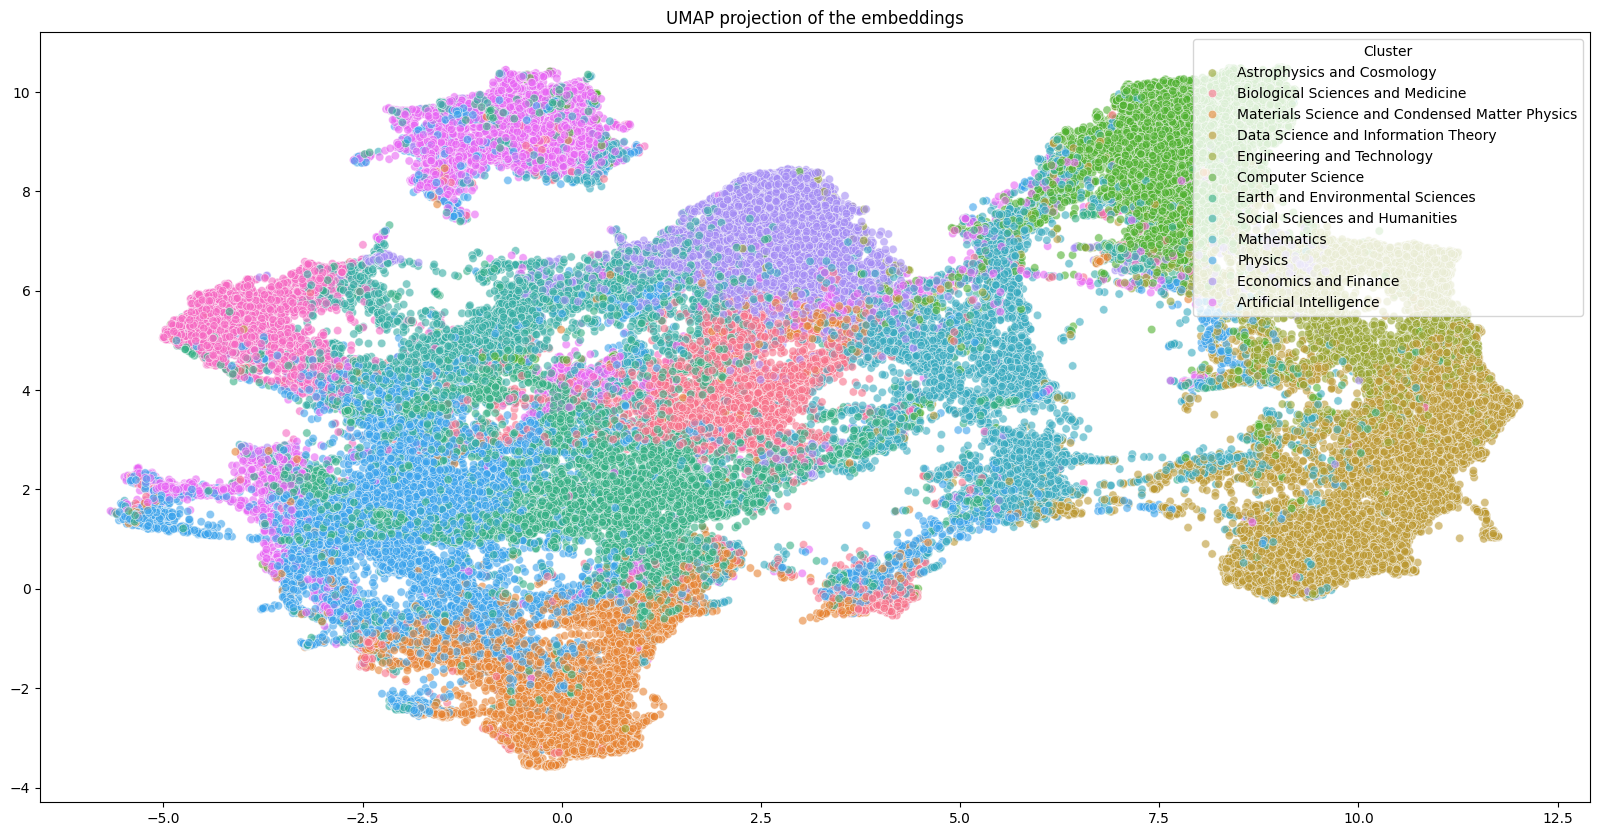

In [97]:
# visualize
plt.figure(figsize=(20, 10))
sns.scatterplot(
    x=umap_embeddings[:, 0],
    y=umap_embeddings[:, 1],
    # hue=sampled_df["super_category"],
    hue=cluster_labels,
    palette=sns.color_palette("husl", num_classes),
    legend="full",
    alpha=.6,
)

plt.title("UMAP projection of the embeddings")
# Add cluster names from df["super_category"]
plt.legend(title="Cluster", loc="upper right", labels=all_categories)
plt.show()

In [25]:
import plotly.express as px

# Create a dataframe for plotly
plot_df = pd.DataFrame(umap_embeddings, columns=['UMAP 1', 'UMAP 2'])
plot_df['Cluster'] = kmeans_labels
plot_df['Class'] = df['cat_id']

# Define markers for actual classes
markers = ['circle', 'square', 'triangle-up', 'diamond', 'triangle-down', 'triangle-left', 'triangle-right', 'pentagon', 'star', 'hexagon']

# Create a new column for marker shapes
plot_df['Marker'] = plot_df['Class'].apply(lambda x: markers[x % len(markers)])

# Plot using plotly
fig = px.scatter(plot_df, x='UMAP 1', y='UMAP 2', color='Cluster', symbol='Marker',
                 title="UMAP embeddings colored by KMeans labels and shaped by actual classes",
                 symbol_map={str(i): marker for i, marker in enumerate(markers)}, width=1800, height=800)

fig.update_traces(marker=dict(size=5))  # Adjust the marker size
fig.show()

In [98]:
# calculate accuracy
def calculate_accuracy(df, kmeans_labels, cat_mapping):
    df["kmeans_labels"] = kmeans_labels
    correct = 0
    total = 0
    for cat, kmeans_label in zip(df["cat_id"], df["kmeans_labels"]):
        if cat == kmeans_label:
            correct += 1
        total += 1

    return correct / total

accuracy = calculate_accuracy(sampled_df, kmeans_labels, cat_mapping)
print(f"Accuracy: {accuracy}")

Accuracy: 0.08087663071219969


In [17]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

embeddings_to_eval = sampled_df["embedding"].tolist().copy()
# Perform KMeans clustering
kmeans = KMeans(n_clusters=num_classes, random_state=42)
cluster_labels = kmeans.fit_predict(embeddings_to_eval)
# Adjusted Rand Index (ARI)
ari = adjusted_rand_score(sampled_df["super_category"], cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

# Normalized Mutual Information (NMI)
nmi = normalized_mutual_info_score(sampled_df["super_category"], cluster_labels)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

# Silhouette Score
silhouette_avg = silhouette_score(embeddings_to_eval, sampled_df["super_category"])
print(f"Silhouette Score: {silhouette_avg:.4f}")

Adjusted Rand Index (ARI): 0.3856
Normalized Mutual Information (NMI): 0.5001
Silhouette Score: 0.0166
